In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from FinancialMachineLearning.features.concurrency import *
from FinancialMachineLearning.multiprocess import multiprocess

In [3]:
dollar = pd.read_csv('../Data/dollar_IVEfuture.csv', index_col = 0, parse_dates = True)
dollar = dollar[~dollar.index.duplicated(keep = 'first')]
dollar

,tick_num,open,high,low,close,volume,cum_buy_volume,cum_ticks,cum_dollar_value
date_time,,,,,,,,,
2009-09-28 09:46:34,80,50.79,51.070,50.7100,51.07,20044,13264,80,1.020027e+06
2009-09-28 09:52:47,142,51.07,51.148,51.0500,51.13,21024,19774,62,1.073986e+06
2009-09-28 09:54:38,201,51.14,51.150,51.1290,51.13,19951,6951,59,1.020145e+06
2009-09-28 09:55:26,243,51.13,51.150,51.1300,51.14,19652,18052,42,1.004999e+06
2009-09-28 10:02:48,339,51.14,51.260,51.0800,51.25,19943,11354,96,1.020512e+06
...,...,...,...,...,...,...,...,...,...
2023-09-14 15:54:32,10930083,162.98,163.060,162.9654,162.98,6186,3983,39,1.008408e+06
2023-09-14 15:59:20,10930131,162.99,163.040,162.9299,163.04,7158,4629,48,1.166735e+06
2023-09-14 15:59:39,10930171,163.04,163.050,162.9900,163.00,6316,3266,40,1.029639e+06


#### Estimated Volatility

In [4]:
from FinancialMachineLearning.features.volatility import daily_volatility
vol = daily_volatility(dollar.close, lookback = 100)

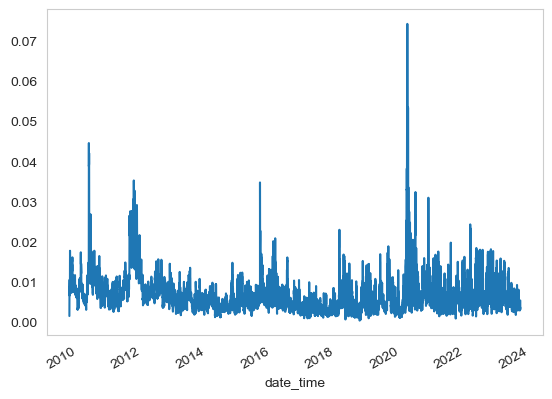

In [6]:
vol.plot()
plt.grid(False)
plt.show()

#### CUSUM Filtering

In [7]:
from FinancialMachineLearning.filter.filter import cusum_filter
cusum_events = cusum_filter(dollar.close, threshold = vol.mean())

#### add Vertical barrier

In [8]:
from FinancialMachineLearning.labeling.labeling import *
vertical_barrier = add_vertical_barrier(cusum_events, dollar['close'], num_days = 1)

#### Triple Barrier Methods

In [9]:
triple_barrier_events = get_events(close = dollar['close'],
                                   t_events = cusum_events[34:],
                                   pt_sl = [1, 1],
                                   target = vol,
                                   min_ret = 0.01,
                                   num_threads = 1,
                                   vertical_barrier_times = vertical_barrier,
                                   side_prediction = None)
triple_barrier_events

,t1,trgt,pt,sl
2009-10-02 09:31:33,2009-10-02 10:35:54,0.010011,1,1
2009-10-02 09:44:59,2009-10-02 10:35:54,0.010268,1,1
2009-10-02 09:53:14,2009-10-05 09:35:17,0.010379,1,1
2009-10-02 10:01:56,2009-10-05 09:35:17,0.010430,1,1
2009-10-02 10:09:13,2009-10-05 09:35:17,0.010453,1,1
...,...,...,...,...
2023-05-08 15:16:20,2023-05-09 15:24:47,0.010701,1,1
2023-05-08 15:16:37,2023-05-09 15:24:47,0.010595,1,1
2023-05-08 15:36:39,2023-05-09 15:40:39,0.010387,1,1
2023-05-08 15:47:11,2023-05-09 15:48:38,0.010283,1,1


#### Concurrency

In [10]:
num_threads = 1
num_conc_events = multiprocess.mp_pandas_obj(concurrent_events, ('molecule', triple_barrier_events.index), num_threads, close_series_index = dollar.close.index, label_endtime = triple_barrier_events['t1'])

In [11]:
# num_conc_events = num_conc_events.loc[~num_conc_events.index.duplicated(keep = 'last')]

num_conc_events = num_conc_events.reindex(dollar.close.index).fillna(0)

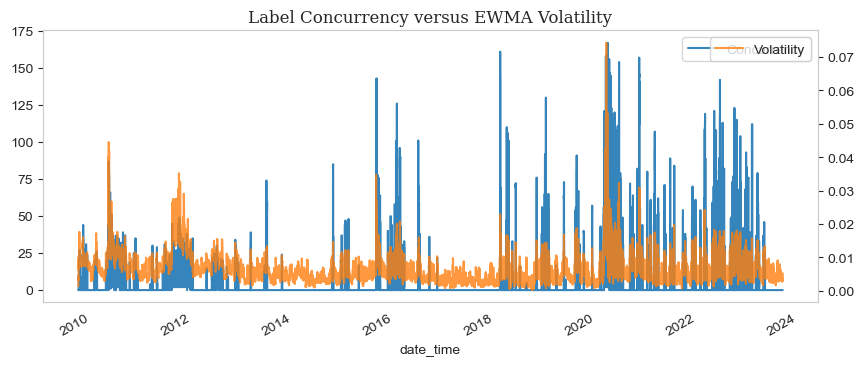

In [13]:
num_conc_events.plot(figsize = (10, 4), alpha = 0.9)
plt.legend(['Concurrency'])
plt.grid(False)
vol.plot(secondary_y = True, alpha = 0.8)
plt.legend(['Volatility'])
plt.grid(False)
plt.title('Label Concurrency versus EWMA Volatility', fontfamily = 'Serif', fontsize = 12)
plt.show()

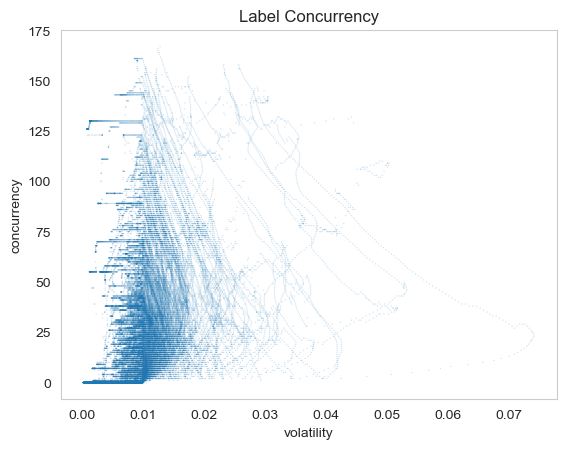

In [31]:
plt.scatter(
    vol[1:], num_conc_events[42:], 
    marker = '.', alpha = 0.2, 
    edgecolor = 'none', s = 4
)
plt.grid(False)
plt.xlabel('volatility')
plt.ylabel('concurrency')
plt.title('Label Concurrency')
plt.show()

#### Uniqueness

In [23]:
avg_unique = multiprocess.mp_pandas_obj(average_uniqueness, ('molecule', triple_barrier_events.index), num_threads, 
                                 label_endtime = triple_barrier_events['t1'], num_conc_events = num_conc_events)
avg_unique

2009-10-02 09:31:33    0.275361
2009-10-02 09:44:59    0.202897
2009-10-02 09:53:14    0.135099
2009-10-02 10:01:56    0.130016
2009-10-02 10:09:13    0.126859
                         ...   
2023-05-08 15:16:20    0.073810
2023-05-08 15:16:37    0.074945
2023-05-08 15:36:39    0.107179
2023-05-08 15:47:11    0.124807
2023-05-08 15:54:13    0.161731
Length: 30053, dtype: float64

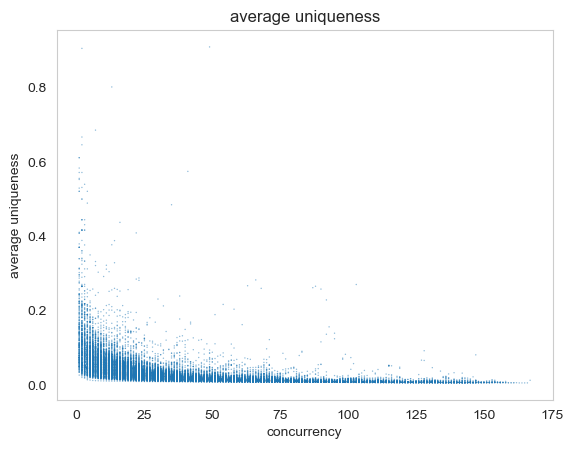

In [35]:
plt.scatter(
    num_conc_events[avg_unique.index],
    avg_unique,
    marker = '.',
    s = 4,
    alpha = 0.5,
    edgecolor = 'none'
)
plt.grid(False)
plt.title('average uniqueness')
plt.xlabel('concurrency')
plt.ylabel('average uniqueness')
plt.show()

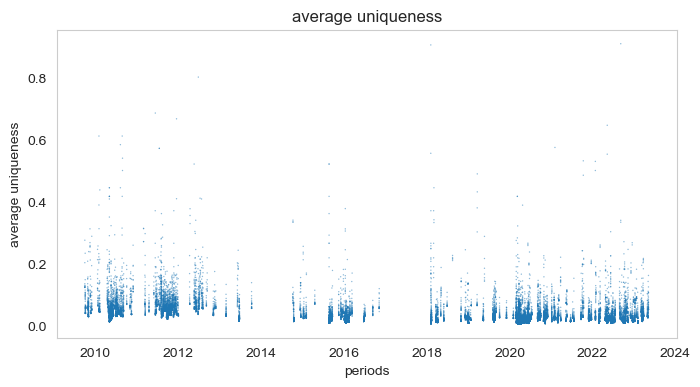

In [39]:
plt.figure(figsize = (8, 4))
plt.scatter(
    avg_unique.index,
    avg_unique,
    marker = '.',
    s = 4,
    alpha = 0.5,
    edgecolor = 'none'    
)
plt.grid(False)
plt.title('average uniqueness')
plt.ylabel('average uniqueness')
plt.xlabel('periods')
plt.show()

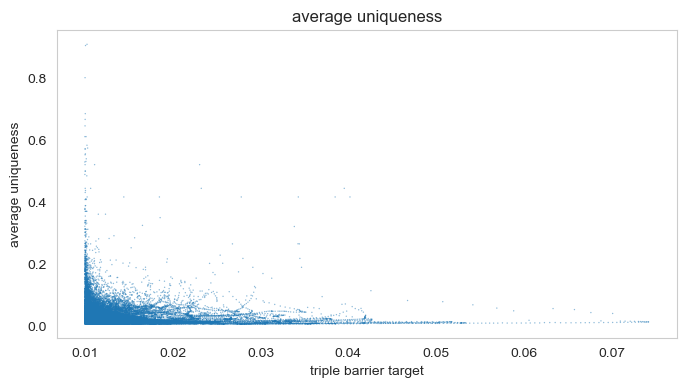

In [42]:
plt.figure(figsize = (8, 4))
plt.scatter(
    triple_barrier_events['trgt'],
    avg_unique,
    marker = '.',
    s = 4,
    alpha = 0.5,
    edgecolor = 'none'    
)
plt.grid(False)
plt.title('average uniqueness')
plt.ylabel('average uniqueness')
plt.xlabel('triple barrier target')
plt.show()


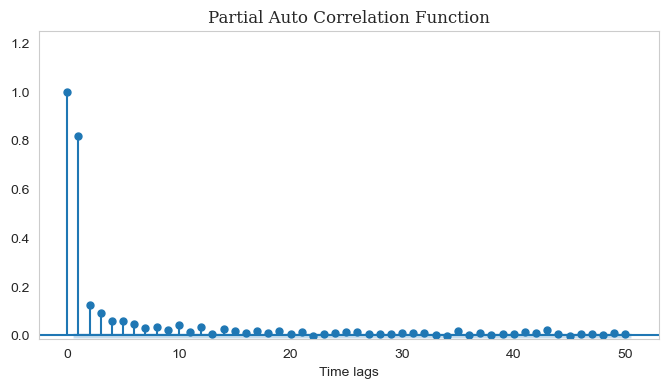

In [44]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig, ax = plt.subplots(figsize=(8, 4))
plot_pacf(avg_unique, auto_ylims = True, lags = 50, ax = ax)
plt.grid(False)
plt.xlabel('Time lags', fontsize = 10)
plt.title('Partial Auto Correlation Function', fontsize = 12, fontfamily = 'Serif')
plt.show()

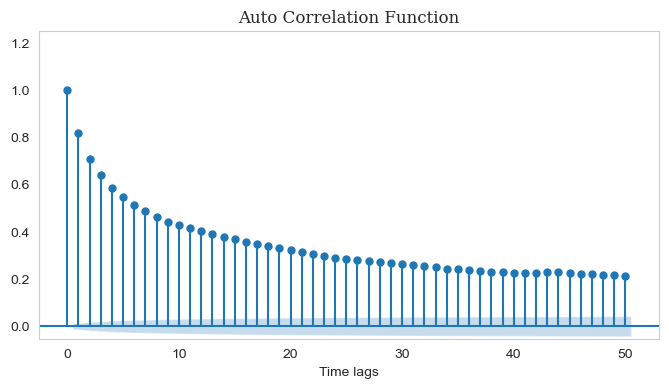

In [45]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig, ax = plt.subplots(figsize=(8, 4))
plot_acf(avg_unique, auto_ylims = True, lags = 50, ax = ax)
plt.grid(False)
plt.xlabel('Time lags', fontsize = 10)
plt.title('Auto Correlation Function', fontsize = 12, fontfamily = 'Serif')
plt.show()

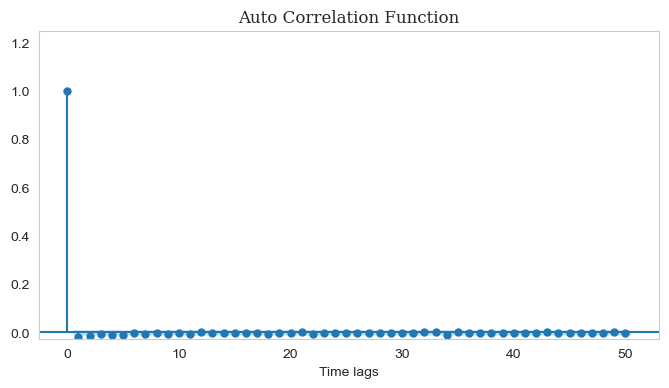

In [49]:
fig, ax = plt.subplots(figsize=(8, 4))
plot_acf(avg_unique.pct_change().dropna(), auto_ylims = True, lags = 50, ax = ax)
plt.grid(False)
plt.xlabel('Time lags', fontsize = 10)
plt.title('Auto Correlation Function', fontsize = 12, fontfamily = 'Serif')
plt.show()

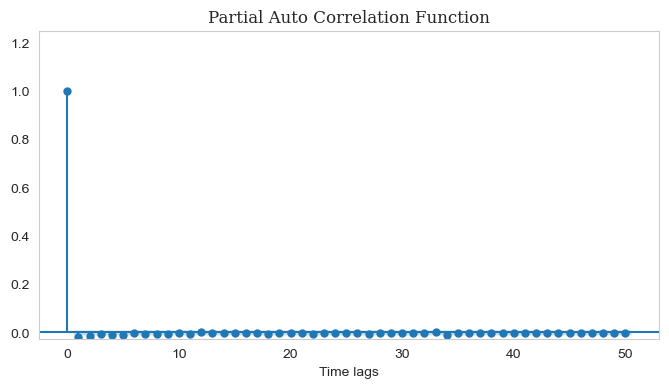

In [50]:
fig, ax = plt.subplots(figsize=(8, 4))
plot_pacf(avg_unique.pct_change().dropna(), auto_ylims = True, lags = 50, ax = ax)
plt.grid(False)
plt.xlabel('Time lags', fontsize = 10)
plt.title('Partial Auto Correlation Function', fontsize = 12, fontfamily = 'Serif')
plt.show()